## graphcol_1

In [1]:
include("todev.jl"); todev()
include("../shared/tomdcode.jl")

tomdcode (generic function with 1 method)

In [2]:
md"""### The `graphcol_1` module
* it only defines the data reading function
"""|>display
tomdcode("src/graphcol_1.jl")

### The `graphcol_1` module

  * it only defines the data reading function


```julia
module graphcol_1

  using DelimitedFiles, Graphs

  function graphcol_1_data()
    # read the data
    d0, h0 = readdlm("../data/synthetic_school_enrollment_data.csv", ','; header = true)
    # convert the original data

    # drop out the first three columns (name,major/minor)
    # and convert it to a valid logical matrix
    data = map(x -> if x == "True"
      true
    elseif x == "False"
      false
    else
      throw(error("unknown value"))
    end, d0[:, 4:end])

    header = h0[4:end]
    num_of_students, num_of_courses = size(data)

    # build the graph:
    # the nodes are the courses with an edge between them if there is a student visiting either.

    # first, collect the set of students visiting each courses
    S = [Set((1:num_of_students)[col]) for col in eachcol(data)]


    # then, use the sets
    G = Graph()
    add_vertices!(G, num_of_courses)
    for i = 1:num_of_courses-1, j = i+1:num_of_courses
      !isdisjoint(S[i], S[j]) && add_edge!(G, i, j)
    end
    (
      G = G,
      num_of_students = num_of_students,
      num_of_courses = num_of_courses,
      header = header,
    )
  end
  export graphcol_1_data


end # of module

```


In [13]:
md"""### The client code
"""|>display
tomdcode("main.jl")

### The client code


```julia
include("todev.jl"); todev()

using graphcol_1

using Graphs, Colors, DataFrames, StatsBase, CairoMakie, GraphMakie


# read the data
data = graphcol_1_data()
G = data.G
num_of_students = data.num_of_students
num_of_courses = data.num_of_courses
header = data.header


# plot the graph
deg = degree(G)
oriG = graphplot(
  G,
  node_size = deg,
  node_color = "Purple",
  edge_color = "LightGray",
  edge_width = 0.5,
)
hidedecorations!(scene.axis)
printstyled("the original graph:\n",color=:blue)
oriG|>display


# as in networkX in Graph.jl there is a "builtin" method 
# greedy_color(G; reps) to generate 
# colorings, therefore we'll use it
# it returns an object w/ num_colors and colors fields
# we need col.num_colors dates for the exams
printstyled("\nexecute greedy_color:\n", color=:blue)
@time the_coloring = greedy_color(G; reps = 100)


dc = distinguishable_colors(the_coloring.num_colors, colorant"blue")

# first is the innermost
the_shells = [[] for c = 1:the_coloring.num_colors]
for v in vertices(G)
  push!(the_shells[the_coloring.colors[v]], v)
end
sort!(the_shells, by = x -> length(x))

colored_G = graphplot(
  G,
  layout = GraphMakie.Shell(; nlist = the_shells),
  node_size = deg,
  node_color = dc[the_coloring.colors],
  edge_color = "LightGray",
  edge_width = 0.5,
)
hidedecorations!(colored_G.axis)
printstyled("the colored graph (shell layout):\n",color=:blue)
colored_G|>display


# we need maxcolsize rooms
cm = the_coloring.colors |> countmap
mincolsize, maxcolsize = extrema(nc for (c, nc) in cm)

# build the final table
# exams for courses with the color 'k' will be held on the 'k'-th date given
table = fill("-", the_coloring.num_colors, maxcolsize) # indices for filling in
idx = fill(0, the_coloring.num_colors)
for i = 1:num_of_courses
  ri = the_coloring.colors[i]
  ci = (idx[ri] += 1)
  table[ri, ci] = header[i]
end


printstyled("\na possible exam schedule:\n", color=:blue)
df = DataFrame(
  hcat("Exam-" .* string.(1:the_coloring.num_colors), table),
  vcat("Exam", "Room-" .* string.(1:maxcolsize)),
)|>display


```


### The output


the original graph:


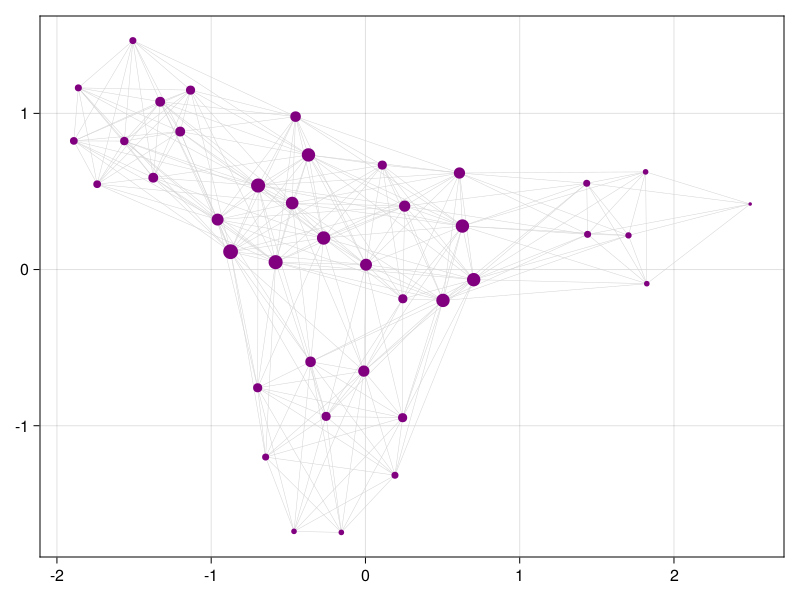


execute greedy_color:
  0.000658 seconds (4.20 k allocations: 423.859 KiB)

the colored graph (shell layout):


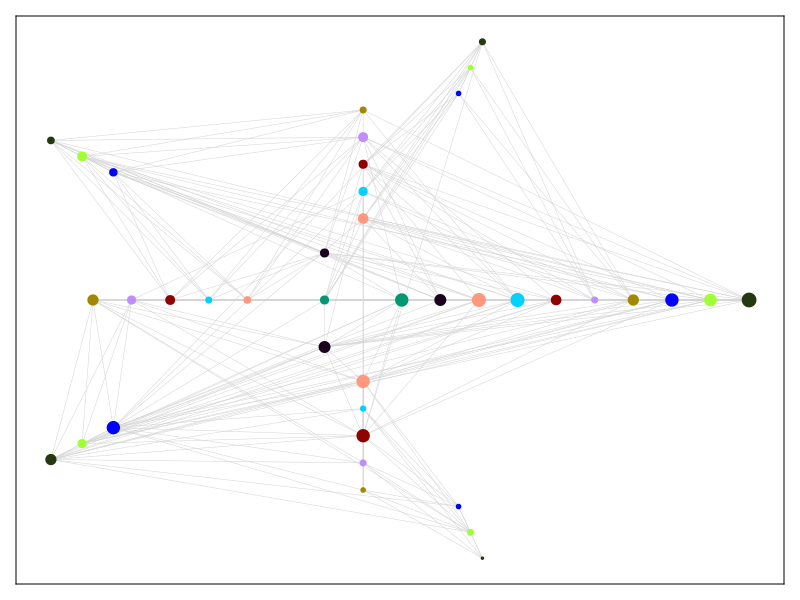


a possible exam schedule:


Row,Exam,Room-1,Room-2,Room-3,Room-4,Room-5
,String,String,String,String,String,String
1,Exam-1,Neurobiology,Programming for Physics,Calculus I,Algorithms,Weather Systems
2,Exam-2,Genetics,Material Science,Probability II,Data Science,Physical Geology
3,Exam-3,Bioinformatics,Robotics,Calculus II,Artificial Inteligence,Tectonics
4,Exam-4,Evolution,Thermodynamics,Statistics II,Programming in C++,-
5,Exam-5,Biology of the Cell,Quantum Mechanics,Linear Algebra,Ecology,-
6,Exam-6,Biochemistry,Nanotechnologies,Statistics I,Programming Introduction,-
7,Exam-7,Classical Mechanics,Geometry,Numerical Methods,Chemical Geology,-
8,Exam-8,Complex Systems,Programming for Mathematics,Software Engineering,Glaciology,-
9,Exam-9,Molecular Biology,Probability I,Machine Learning,-,-


In [14]:
md"""### The output
"""|>display
include("main.jl")

#### Note
* inspecting the data and the result in the original tutorial more closely one can found that the 2021-06-15 18:00 Bioinformatics and Data Science exams share a student, namely Katrina Scott (Computer Science major/no minor). So, the tutorial's program has some error (which explains why we see different number of edges in the graphs)